## Importing the libraries

In [1]:
import copy
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dtaidistance import dtw
from fastdtw import fastdtw
from scipy import signal
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.signal import find_peaks
from collections import defaultdict
import torch
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
from astropy.time import Time
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering

## Data loading

The dictionary `fullstationdata` contains pressure time series for all stations with a sampling frequency of 1 hour. 

Each data point is associated with a timestamp. 

In [2]:
def createpres(p):
  p = p[0].values.tolist()
  return p


names = pd.read_csv(r'channels.tbl.20250303', delimiter=' ')
names = names.T.values.tolist()
pathtopressure = r'data\2025_14days'
presnames = names[0]
sequence_length = len(createpres(pd.read_csv(pathtopressure + presnames[0] + '.dat', delimiter='\t', header=None)))
num_stations = len(names[0])

pressure_n = []
fullstationdata = {}

for i in range(num_stations):
  pressure_n = createpres(pd.read_csv(pathtopressure + presnames[i] + '.dat', delimiter='\t', header=None))
  fullstationdata[f'station_{i}'] = pd.Series(pressure_n, index=pd.date_range("2025-02-23", periods=sequence_length, freq="h"))

print(0)

0


## Base predictors

Below are the functions for four basic predictors (`method1`, ..., `method4`). Each basic predictor takes the following as input:

1) A dictionary in a format similar to `fullstationdata`
2) A `names` file containing a list of station information (names, coordinates, depths, etc.). When requesting data from the NIED website, this file is provided together with the pressure registration data.
3) An array `test` containing the indices of stations to be included in the test set. The remaining stations are automatically used for training. By default, this array is empty.

Each basic predictor returns two arrays with the distributions of the reconstruction error magnitude for each station. The index in the array corresponds to the station number. The first returned array contains errors calculated using the *MSE* error function, and the second — using *DTW*.

Predictors `method2`, `method3`, and `method4` are used in the final meta-classifier, while `method1` can be used separately if necessary.

In [3]:
#Spectral method

def method1(station_data, names, test=[]):
    def countpeaks(n=72):
      def plot_spectrum(time, signal):
          dt = time[1] - time[0]
          spectrum = np.fft.fft(signal)
          freqs = np.fft.fftfreq(len(signal), d=dt)
          mask = freqs > 0
          return freqs[mask], np.abs(spectrum[mask])
      signal = station_data['station_'+str(n)]
      time = np.linspace(0, len(signal), len(signal), endpoint=False)
      f, s = plot_spectrum(time, signal)
      fmin = 0.02
      fmax = 0.1
      indices = np.where((f >= fmin) & (f <= fmax))
      s = s[indices]
      f = f[indices]
      peaks, _ = find_peaks(s, distance=5, height=np.max(s)/2)
      np.diff(peaks)
      return len(peaks), 1/f[peaks]
    num_stations = len(names[0])
    loss=np.zeros(num_stations)

    for i in range(num_stations):
      number, peaks = countpeaks(i)
      if number != 2:
        #print('n', names[0][i], names[3][i], i)
        loss[i] = -1
      else:
        loss[i] = (peaks[0]-24)**2 + (peaks[1]-12)**2

    for i in range(num_stations):
        if loss[i]==-1:
            loss[i]=np.max(loss)*1.1

    K = num_stations
    indices = np.argpartition(loss, -K)[-K:]

    return(loss, loss)

In [4]:
#Clusters

def method2(station_data, names, test=[]):
    stations = list(station_data.keys())
    n_stations = len(stations)

    station_data_normalized = {}

    for station, series in station_data.items():
        values = series.values
        mean = np.mean(values)
        std = np.std(values)
        if std == 0:
            std = 1  # на случай константных рядов
        normalized_values = (values - mean) / std
        station_data_normalized[station] = pd.Series(normalized_values, index=series.index)

    dtw_distances = np.zeros((n_stations, n_stations))
    mse_distances = np.zeros((n_stations, n_stations))

    for i in range(n_stations):
        for j in range(i + 1, n_stations):
            distancedtw, _ = fastdtw(station_data_normalized[stations[i]].values, station_data_normalized[stations[j]].values)
            dtw_distances[i, j] = distancedtw
            dtw_distances[j, i] = distancedtw  # симметрия
            distancemse = mean_squared_error(station_data_normalized[stations[i]].values, station_data_normalized[stations[j]].values)
            mse_distances[i, j] = distancemse
            mse_distances[j, i] = distancemse  # симметрия

    n_clusters = 1

    clustering = AgglomerativeClustering(
        metric='precomputed',
        linkage='average',
        n_clusters=n_clusters
    )
    labelsdtw = clustering.fit_predict(dtw_distances)
    labelsmse = clustering.fit_predict(mse_distances)


    cluster_seriesdtw = {}
    for label in np.unique(labelsdtw):
        cluster_seriesdtw[label] = []
    cluster_seriesmse = {}
    for label in np.unique(labelsmse):
        cluster_seriesmse[label] = []

    for station, label in zip(stations, labelsdtw):
        cluster_seriesdtw[label].append(station_data_normalized[station].values)

    for station, label in zip(stations, labelsmse):
        cluster_seriesmse[label].append(station_data_normalized[station].values)

    cluster_centersdtw = {}
    cluster_centersmse = {}
    for label, series_list in cluster_seriesdtw.items():
        cluster_centersdtw[label] = np.mean(series_list, axis=0)

    for label, series_list in cluster_seriesmse.items():
        cluster_centersmse[label] = np.mean(series_list, axis=0)


    station_distancesdtw = []
    station_distancesmse = []

    for station, label in zip(stations, labelsdtw):
        signal = station_data_normalized[station].values
        center = cluster_centersdtw[label]
        distancedtw = np.linalg.norm(signal - center)
        station_distancesdtw.append(distancedtw)

    for station, label in zip(stations, labelsmse):
        signal = station_data_normalized[station].values
        center = cluster_centersmse[label]
        distancemse = np.linalg.norm(signal - center)
        station_distancesmse.append(distancemse)

    station_distancesdtw = np.array(station_distancesdtw)
    station_distancesmse = np.array(station_distancesmse)


    return(station_distancesmse.tolist(), station_distancesdtw.tolist())

In [5]:
#Physical model

def method3(station_data, names, test=[]):
    def datetime_to_mjd(dt_array):
        t = Time(dt_array, format='datetime')
        return t.mjd

    def makepredict(names, i, times):
        latitude = names[13][i]
        longitude = names[14][i]

        model_directory = 'PO/DATA'
        grid_file = f'{model_directory}/grid_PO'
        model_file = f'{model_directory}/hf.PO_2009.out'
        tide_times = datetime_to_mjd(times)

        amp, ph, D, c = extract_constants(
            np.array([longitude]),
            np.array([latitude]),
            projection='EPSG:4326',
            grid_file=grid_file,
            model_file=model_file,
            type='z',
            method='nearest',
            grid='OTIS'
        )

        tide = time_series(
            tide_times,
            amp,
            c,
            deltat=0.0,
            corrections='OTIS'
        )
        return tide

    # 1. Take timestamps from station_data
    sample_key = list(station_data.keys())[0]
    sample_index = station_data[sample_key].index
    times = sample_index.to_pydatetime()

    # 2. Generate predict_data for these timestamps
    predict_data = {}
    for i in range(len(names[0])):
        tide = makepredict(names, i, times)
        predict_data[f'station_{i}'] = pd.Series(tide, index=sample_index)

    # 3. Calculate errors
    lossesdtw = []
    lossesmse = []

    for i in range(len(names[0])):
        pr_full = predict_data[f'station_{i}']
        re_full = station_data[f'station_{i}']

        if not re_full.index.isin(pr_full.index).all():
            raise ValueError(f"predict_data['station_{i}'] does not contain required timestamps.")

        pr = pr_full.loc[re_full.index]
        re = (re_full - np.mean(re_full)) / 10000

        lossesdtw.append(dtw.distance(pr, re))
        lossesmse.append(np.mean((re - pr) ** 2))

    return lossesmse, lossesdtw


In [6]:
#SARIMA

def method4(station_data, names, test=[]):
  warnings.filterwarnings("ignore", category=UserWarning)
  warnings.filterwarnings("ignore", category=FutureWarning)

  # Check if GPU is available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  # Normalization
  def normalize(series):
      return (series - series.mean()) / series.std(), series.mean(), series.std()

  # Denormalization
  def denormalize(series, mean, std):
      return series * std + mean

  # Function for ritting SARIMA and building the forecast
  def fit_sarima_and_predict(train_data, order=(1,1,1), seasonal_order=(1,1,1,24), steps=24):
      model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
      results = model.fit(disp=False)
      forecast = results.get_forecast(steps=steps).predicted_mean
      return forecast

  # Calculate DTW and MSE errors for each station
  lossesmse = []
  lossesdtw = []
  reconstructed_data_mse = {}
  reconstructed_data_dtw = {}
  sequence_length = len(station_data[f'station_{0}'])
  train_size = int(sequence_length * 3 / 4)  # first 3/4 of the singal to train, the rest 1/4 to test

  def predict_and_evaluate_dtw(station, data_series):
      train_data, mean, std = normalize(data_series.iloc[:train_size])
      test_data = data_series.iloc[train_size:] 

      predicted_values = fit_sarima_and_predict(train_data, steps=len(test_data))
      predicted_values = denormalize(predicted_values, mean, std)

      data_tensor = torch.tensor(test_data.values, dtype=torch.float32, device=device)
      predicted_tensor = torch.tensor(predicted_values.values, dtype=torch.float32, device=device)
      #mse = torch.mean((data_tensor - predicted_tensor) ** 2).item()
      mse = dtw.distance(data_tensor, predicted_tensor)

      return mse, predicted_values


  def predict_and_evaluate_mse(station, data_series):
      train_data, mean, std = normalize(data_series.iloc[:train_size])
      test_data = data_series.iloc[train_size:]  

      predicted_values = fit_sarima_and_predict(train_data, steps=len(test_data))
      predicted_values = denormalize(predicted_values, mean, std)

      data_tensor = torch.tensor(test_data.values, dtype=torch.float32, device=device)
      predicted_tensor = torch.tensor(predicted_values.values, dtype=torch.float32, device=device)
      mse = torch.mean((data_tensor - predicted_tensor) ** 2).item()
      #mse = dtw.distance(data_tensor, predicted_tensor)

      return mse, predicted_values



  for station, data_series in station_data.items():
      mse, predicted_values = predict_and_evaluate_mse(station, data_series)
      lossesmse.append(mse)
      reconstructed_data_mse[station] = predicted_values

  for station, data_series in station_data.items():
      mse, predicted_values = predict_and_evaluate_dtw(station, data_series)
      lossesdtw.append(mse)
      reconstructed_data_dtw[station] = predicted_values

  max_finite_value = np.max(np.array(lossesmse)[np.isfinite(lossesmse)])
  lossesmse = [loss if np.isfinite(loss) else max_finite_value for loss in lossesmse]
  max_finite_value = np.max(np.array(lossesdtw)[np.isfinite(lossesdtw)])
  lossesdtw = [loss if np.isfinite(loss) else max_finite_value for loss in lossesdtw]

  return(lossesmse, lossesdtw)


## Function for metaclassifier training

The function computes the final prediction of whether a station belongs to one of two classes: functional (good) or malfunctioning (bad). The inputs are:

1) `errors` - a list of 6 error arrays (3 methods, 2 error functions for each)
2) `Testidx` - a list of station indices assigned to the test set; the remaining stations are used for training.
3) `bad` - a list of indices of malfunctioning stations (labels). Stations whose indices are not included in this list are considered functional.
4) `pics` - the variable is set to `True` if the ROC curve, feature importance plot, and classification report should be displayed. If set to `False`, no plots are generated.
5) `method_names` - a list of method names for display in the feature importance plot.

The function returns the trained model, the normalizer, and the f1-score for the *malfunctioning* class as the primary metric.

In [11]:
def train_meta_classifier_with_plots(errors, Testidx, bad, pics, method_names=None):
    N = len(errors[0])
    assert all(len(arr) == N for arr in errors), "All arrays should have the same length"

    # Matrix of features X: (N, 5)
    X = np.stack(errors, axis=1)

    # 1 = malfunctioning, 0 = functional
    y = np.zeros(N, dtype=int)
    y[bad] = 1

    # train/test
    test_mask = np.zeros(N, dtype=bool)
    test_mask[Testidx] = True
    train_mask = ~test_mask

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    # Normalization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_scaled, y_train)

    # Forecast
    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    report = classification_report(y_test, y_pred, target_names=["good", "bad"], output_dict=True)

    if pics:
        print("Accuracy:", acc)
        print("ROC AUC:", auc)
        print("Classification report:")
    
        print(classification_report(y_test, y_pred, target_names=["good", "bad"]))

        # ROC-curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    # Feature importance
        importances = clf.feature_importances_
        if method_names is None:
            method_names = [f"Method {i+1}" for i in range(X.shape[1])]

        plt.figure(figsize=(7, 4))
        plt.bar(method_names, importances, color="skyblue")
        plt.title("Feature Importances")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()

    return clf, scaler, report['bad']['f1-score']


## Function for train-test splitting

The data may have hidden internal dependencies, so the split into training and test sets is performed under certain mandatory conditions:
1) If two (or more) sensors are installed at the same station, they are either both included in the test set or both in the training set, but never split.
2) All samples for the same station are kept together so that the classifier does not simply “learn to guess the station” instead of determining whether it is functional or malfunctioning.
3) The ratio of good:bad in the test and training sets is kept approximately the same as in the original data. However, this ratio can be adjusted by changing the parameters `K` and `N` (see below).

The function takes as input:
1) Array `names` to identify which sensors belong to the same station
2) Array `bad` with indices of faulty stations (the rest are operational)
3) `K` - the minimum number of faulty (bad) sensors that must be included in the test set
4) `N` - the minimum number of all stations that must be included in the test set
5) `seed` - the seed for random station selection

The function returns a list of sensor indices included in the test set. All others are used for training.

In [13]:
def select_grouped_stations(names, bad, K, N, seed=None):
    if seed is not None:
        random.seed(seed)
    
    num_stations = len(names[0])
    indices = list(range(num_stations))

    # names[3][i] - name of the i-th station
    groups = defaultdict(list)
    for i in indices:
        key = names[3][i]
        groups[key].append(i)
    
    # Grouping
    group_categories = {'bad': [], 'neutral': []}
    bad_set = set(bad)

    for group in groups.values():
        group_set = set(group)
        if group_set & bad_set:
            group_categories['bad'].append(group)
        else:
            group_categories['neutral'].append(group)

    def select_groups_with_limit(group_list, target_count, current_total, max_total):
        random.shuffle(group_list)
        selected = []
        selected_count = 0
        for group in group_list:
            group_len = len(group)
            if selected_count >= target_count:
                break
            if current_total + group_len > max_total:
                continue  # Skip the group if it does not fit in
            selected.append(group)
            selected_count += group_len
            current_total += group_len
        return selected, selected_count, current_total

    # Group selection
    selected_bad, count_bad, total_count = select_groups_with_limit(group_categories['bad'], K, 0, N)

    selected_neutral, count_neutral, total_count = select_groups_with_limit(
        group_categories['neutral'], N - (count_bad), total_count, N
    )

    selected_groups = selected_bad + selected_neutral
    final_selection = [i for group in selected_groups for i in group]

    return final_selection

## Running the base predictors

In the following code section, the original 14-day dataset is split into 4 segments of 84 hours each (3.5 days). The array `start` contains the starting points of the samples, and the array `end` contains the ending points. If the data segmentation into samples is to be changed, it is strongly recommended to keep the samples the same length. Each such segment is treated as a separate sample. All samples for each method are collected into a single array of length `4N`, where `N` is the number of sensors in the original dataset. Samples with indices `k`, `k+N`, `k+2N`, `k+3N` correspond to the same station but for different time segments.

The list of faulty stations (`worst`) is similarly replicated 4 times, each time with an offset of `N`, to account for the fact that if a station is faulty, it remains faulty for all time segments.

The `select_grouped_stations` function is used to split the data into training and test sets.

If the variable `need_to_calculate` is set to `False`, the error distributions are loaded from the files in the `errors` folder. If set to `True`, all distributions are recalculated using the basic classifiers (time-consuming). The `method2` classifier always recalculates the error distribution, since it is the only method whose result depends on the train/test split (which in general depends on the random seed).

The error distributions for all methods are collected into a common list `errors`.

In the last cell, the training of the meta-classifier itself is launched (relatively fast if the error distributions have already been loaded or calculated).

In [14]:
def write(fullstationdata, method, start, end, test):
    arr_mse = []
    arr_dtw = []
    station_data = {}
    for i in range(len(start)):
        start_idx = start[i]
        end_idx = end[i]
        
        for key in fullstationdata:
            station_data[key] = fullstationdata[key].iloc[start_idx:end_idx]
        a = method(station_data, names, test)
        arr_mse += a[0]
        arr_dtw += a[1]
    return arr_mse, arr_dtw

start = [0, 84, 168, 252]
end = [84, 168, 252, 336]
worst = [15, 16, 37, 38, 51, 52, 72, 73, 74, 86, 87, 125, 126, 152, 153, 179, 180, 207, 208, 215, 216, 90, 91, 23, 24, 80, 81, 203, 204]

bad = worst.copy()
bad += [x + num_stations for x in worst]
bad += [x + num_stations*2 for x in worst]
bad += [x + num_stations*3 for x in worst]

# for the station which failed during observation first two samples should be labelled as functioning
bad.remove(80)
bad.remove(81)
bad.remove(336)
bad.remove(337)

K = len(worst)//4 # bad
N = len(names[0])//4  # bad + good

selected = select_grouped_stations(names, worst, K, N, seed=42)
print(f"Number of selected stations: {len(selected)} stations")
print(f"Number of bad stations among selected: {len(set(selected) & set(bad))}")

Testidx = selected.copy()  
Testidx += [x + num_stations for x in selected]
Testidx += [x + num_stations*2 for x in selected]
Testidx += [x + num_stations*3 for x in selected]



need_to_calculate = False # Set to "True" if you need to calculate all the distributions again, to "False" if errors are imported from files


errors = []
er=write(fullstationdata, method2, start, end, selected)
errors.append(er[0])
#errors.append(er[1])

if need_to_calculate:
    er=write(fullstationdata, method3, start, end, selected)
    errors.append(er[0])
    errors.append(er[1])
    er=write(fullstationdata, method4, start, end, selected)
    errors.append(er[0])
    errors.append(er[1])
else:
    errors.append(pd.read_csv(r'errors\method3MSEfull.txt', header=None).T.values.tolist()[0])
    errors.append(pd.read_csv(r'errors\method3DTWfull.txt', header=None).T.values.tolist()[0])
    errors.append(pd.read_csv(r'errors\method4MSEfull.txt', header=None).T.values.tolist()[0])
    errors.append(pd.read_csv(r'errors\method4DTWfull.txt', header=None).T.values.tolist()[0])

Number of selected stations: 64 stations
Number of bad stations among selected: 6


Accuracy: 0.98828125
ROC AUC: 0.9971804511278195
Classification report:
              precision    recall  f1-score   support

        good       0.99      1.00      0.99       228
         bad       0.96      0.93      0.95        28

    accuracy                           0.99       256
   macro avg       0.98      0.96      0.97       256
weighted avg       0.99      0.99      0.99       256



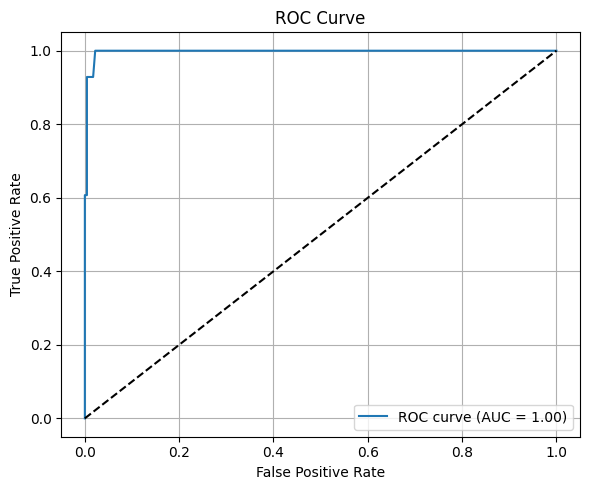

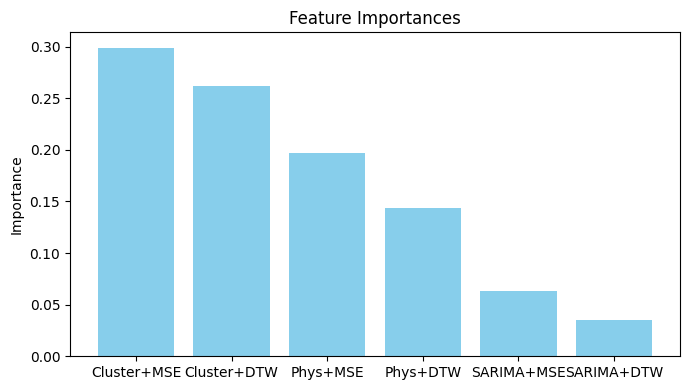

In [11]:
method_names = ["Cluster", "Phys+MSE", "Phys+DTW", "SARIMA+MSE", "SARIMA+DTW"]

# training and visualization
model, scaler, fsc1= train_meta_classifier_with_plots(errors, Testidx, bad, True, method_names=method_names)